In [1]:
# !pip install pyspark

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd

In [3]:
# Criação da sessão Spark
spark = SparkSession.builder \
    .appName("PySpark BigQuery Connection") \
    .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.2') \
    .config("spark.jars", "/usr/local/lib/spark-connectors/bigquery-connector-hadoop2-latest.jar") \
    .getOrCreate()

24/09/29 14:20:51 WARN Utils: Your hostname, spark-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/09/29 14:20:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/spark/.ivy2/cache
The jars for the packages stored in: /home/spark/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8bddf649-fe17-472e-b328-a95fdfa92013;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.2 in central
:: resolution report :: resolve 1266ms :: artifacts dl 21ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	-----------------------------------------------------------------

In [4]:
spark.conf.set("viewsEnabled", True)
spark.conf.set("materializationDataset", "SOT")

In [5]:
sc = spark.sparkContext
sc.setLogLevel("INFO")
sc._jsc.hadoopConfiguration().set('fs.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem')
sc._jsc.hadoopConfiguration().set('fs.gs.auth.service.account.json.keyfile', '/usr/local/lib/gcp/credentials/my-project-1508437523553-e9bafe7e3368.json')

In [6]:
# Função para salvar DataFrame em formato Parquet
def save_to_bigquery(df, dataset, table_name):
    # Salva o DataFrame em formato Parquet
    df.write \
    .format("bigquery") \
    .option("table", f"{dataset.upper()}.{table_name}") \
    .option("temporaryGcsBucket", "meu-bucket-temporario-spark") \
    .option("credentialsFile", "/usr/local/lib/gcp/credentials/my-project-1508437523553-e9bafe7e3368.json") \
    .mode("overwrite") \
    .save()

In [7]:
# Função para ler dados do BigQuery
def read_from_bigquery(dataset, table_name):  
    df = spark.read \
        .format('bigquery') \
        .option('table', f"{dataset.upper()}.{table_name}") \
        .option("credentialsFile", "/usr/local/lib/gcp/credentials/my-project-1508437523553-e9bafe7e3368.json") \
        .load()

    return df

In [8]:
df = read_from_bigquery('SOT', 'tbx001_data')
df.createOrReplaceTempView("tbx001_data")

In [98]:
# filtrar pegando o ultimo ano na coluna "ano" e os ultimos 3 meses na coluna "mes"
df = spark.sql("""
    SELECT 
        TRIM(uf) AS uf,
        TRIM(ano) AS ano,
        TRIM(mes) AS mes,
        TRIM(semana) AS semana,
        TRIM(ano_nascimento) AS ano_nascimento,
        TRIM(sexo) AS sexo,
        TRIM(cor_raca) AS cor_raca,
        TRIM(tipo_area) AS tipo_area,
        TRIM(escolaridade) AS escolaridade,
        TRIM(teve_sintomas_covid) AS teve_sintomas_covid,
        TRIM(foi_posto_saude) AS foi_posto_saude,
        TRIM(ficou_em_casa) AS ficou_em_casa,
        TRIM(ficou_internado) AS ficou_internado,
               case 
               when TRIM(ficou_internado) = 'Sim' or TRIM(foi_posto_saude) = 'Sim' then 'Sim'
               when TRIM(foi_posto_saude) is null and TRIM(ficou_internado) is null then null
               when TRIM(ficou_internado) is not null then TRIM(ficou_internado)
               when TRIM(foi_posto_saude) is not null then TRIM(foi_posto_saude)
               end as foi_ao_hospital,                  
        TRIM(teve_covid) AS teve_covid,
        TRIM(resultado_covid) AS resultado_covid,
        TRIM(tem_plano_saude) AS tem_plano_saude,
        TRIM(faixa_rendimento) AS faixa_rendimento,
        TRIM(situacao_domicilio) AS situacao_domicilio
    FROM tbx001_data
    WHERE ano = (SELECT MAX(ano) FROM tbx001_data)
    AND mes IN (SELECT mes FROM tbx001_data WHERE ano = (SELECT MAX(ano) FROM tbx001_data) group by mes ORDER BY mes DESC LIMIT 3)
""")


In [99]:
df.printSchema()

root
 |-- uf: string (nullable = true)
 |-- ano: string (nullable = true)
 |-- mes: string (nullable = true)
 |-- semana: string (nullable = true)
 |-- ano_nascimento: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- cor_raca: string (nullable = true)
 |-- tipo_area: string (nullable = true)
 |-- escolaridade: string (nullable = true)
 |-- teve_sintomas_covid: string (nullable = true)
 |-- foi_posto_saude: string (nullable = true)
 |-- ficou_em_casa: string (nullable = true)
 |-- ficou_internado: string (nullable = true)
 |-- foi_ao_hospital: string (nullable = true)
 |-- teve_covid: string (nullable = true)
 |-- resultado_covid: string (nullable = true)
 |-- tem_plano_saude: string (nullable = true)
 |-- faixa_rendimento: string (nullable = true)
 |-- situacao_domicilio: string (nullable = true)



In [100]:
# Alterando o tipo da coluna "ano, mes, semana, ano_nascimento" para inteiro
df = df.withColumn("ano", df["ano"].cast(T.IntegerType()))\
    .withColumn("mes", df["mes"].cast(T.IntegerType()))\
    .withColumn("semana", df["semana"].cast(T.IntegerType()))\
    .withColumn("ano_nascimento", df["ano_nascimento"].cast(T.IntegerType()))

In [101]:
df_pandas = df.toPandas()

24/09/29 15:41:43 INFO DirectBigQueryRelation: |Querying table my-project-1508437523553.SOT.tbx001_data, parameters sent from Spark:|requiredColumns=[uf,ano,mes,semana,ano_nascimento,sexo,cor_raca,tipo_area,escolaridade,teve_sintomas_covid,foi_posto_saude,ficou_em_casa,ficou_internado,teve_covid,resultado_covid,tem_plano_saude,faixa_rendimento,situacao_domicilio],|filters=[IsNotNull(ano)]
24/09/29 15:41:45 INFO ReadSessionCreator: Read session:{"readSessionName":"projects/my-project-1508437523553/locations/us-east1/sessions/CAISDFo5U3M0bGd0dm9VUBoCdngaAnVo","readSessionCreationStartTime":"2024-09-29T18:41:43.785Z","readSessionCreationEndTime":"2024-09-29T18:41:45.038Z","readSessionPrepDuration":636,"readSessionCreationDuration":617,"readSessionDuration":1253}
24/09/29 15:41:45 INFO ReadSessionCreator: Requested 20000 max partitions, but only received 4 from the BigQuery Storage API for session projects/my-project-1508437523553/locations/us-east1/sessions/CAISDFo5U3M0bGd0dm9VUBoCdngaAnV

In [70]:
# !pip install matplotlib
# !pip install seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


In [125]:
# Configurando o estilo do gráfico
sns.set(style="whitegrid", context="talk", font_scale=0.8)

In [126]:
# Tamanho da base para conferência
print(f"Quantidade de registros: {len(df_pandas)}")

Quantidade de registros: 1149197


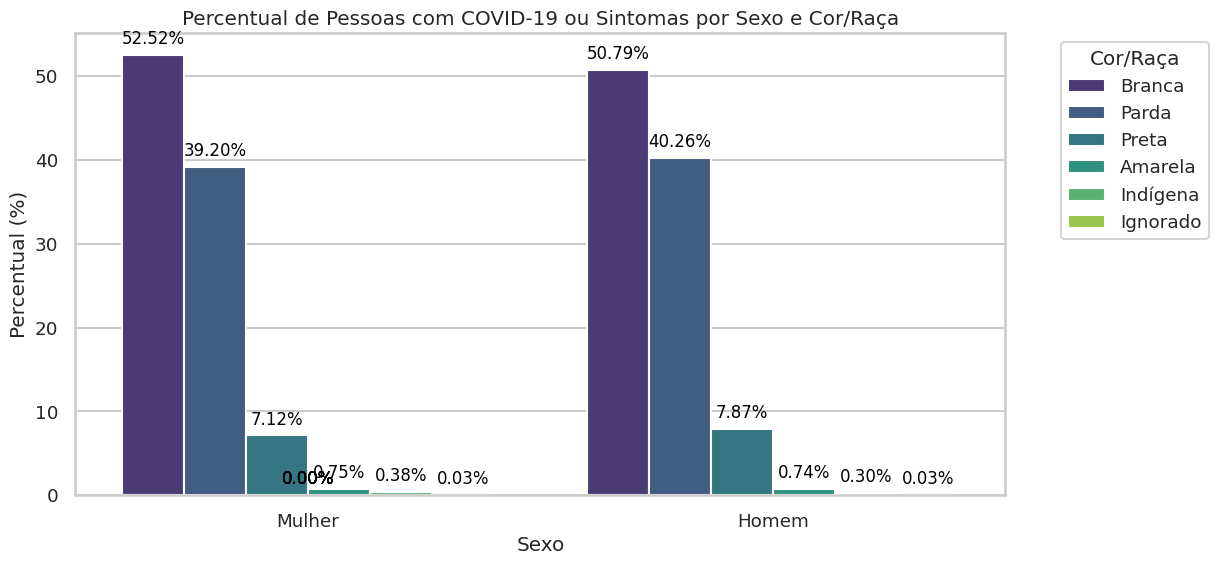

In [145]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19 ou teve COVID-19 confirmado
df_filtrado = df_pandas[(df_pandas['teve_sintomas_covid'] == 'Sim') | (df_pandas['teve_covid'] == 'Sim')]

# Agrupando por sexo, cor_raca e teve_covid para obter as contagens
df_sexo_cor_raca_covid = df_filtrado.groupby(['sexo', 'cor_raca', 'teve_covid']).size().reset_index(name='count')

# Calculando o percentual relativo ao total por sexo e cor_raca
df_sexo_cor_raca_covid['percentual'] = df_sexo_cor_raca_covid.groupby(['sexo', 'teve_covid'])['count'].transform(lambda x: x / x.sum() * 100)

# Filtrando apenas para 'teve_covid' == 'Sim' para a visualização
df_sexo_cor_raca_covid = df_sexo_cor_raca_covid[df_sexo_cor_raca_covid['teve_covid'] == 'Sim']

# Ordenando por percentual para exibição clara
df_sexo_cor_raca_covid = df_sexo_cor_raca_covid.sort_values(by=['percentual'], ascending=False)

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))  # Definindo o tamanho da figura

# Plotando o gráfico de barras com Seaborn
ax = sns.barplot(
    data=df_sexo_cor_raca_covid, 
    x='sexo', 
    y='percentual', 
    hue='cor_raca',  # Definindo a cor das barras por cor/raça
    palette='viridis',  # Escolhendo uma paleta de cores
)

# Adicionando rótulos e título ao gráfico
plt.title('Percentual de Pessoas com COVID-19 ou Sintomas por Sexo e Cor/Raça')
plt.xlabel('Sexo')
plt.ylabel('Percentual (%)')
plt.legend(title='Cor/Raça', bbox_to_anchor=(1.05, 1), loc='upper left')  # Posicionando a legenda fora do gráfico

# Adicionando os valores no topo das barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Exibindo o gráfico
plt.show()

/tmp/ipykernel_2412/2323905186.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_sintomas_covid, x='foi_ao_hospital', y='percentual', palette='viridis')


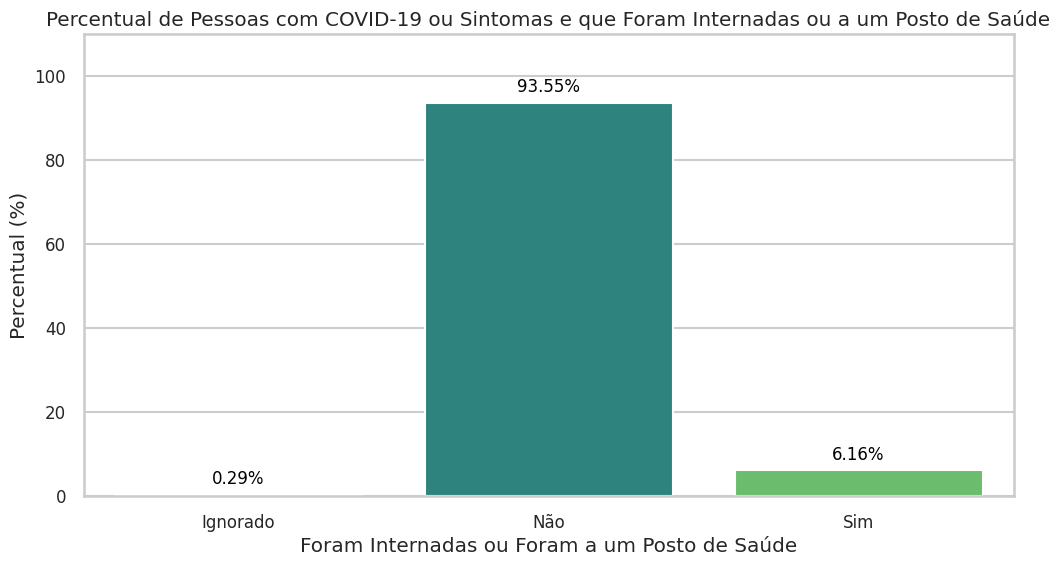

In [179]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19 ou teve COVID-19 confirmado
df_filtrado = df_pandas[(df_pandas['teve_sintomas_covid'] == 'Sim') | (df_pandas['teve_covid'] == 'Sim')]

# Agrupando para obter a contagem de pessoas que foram internadas ou a um posto de saúde
df_sintomas_covid = df_filtrado.groupby(['foi_ao_hospital']).size().reset_index(name='count')

# Calculando o percentual em relação ao total de pessoas no DataFrame filtrado
total_count = df_sintomas_covid['count'].sum()
df_sintomas_covid['percentual'] = (df_sintomas_covid['count'] / total_count) * 100

# Criando o gráfico de barras para o percentual de pessoas que foram ao hospital ou não
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_sintomas_covid, x='foi_ao_hospital', y='percentual', palette='viridis')

# Adicionando rótulos e título ao gráfico
plt.title('Percentual de Pessoas com COVID-19 ou Sintomas e que Foram Internadas ou a um Posto de Saúde')
plt.xlabel('Foram Internadas ou Foram a um Posto de Saúde')
plt.ylabel('Percentual (%)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adicionando os valores no topo das barras com ajuste de posição
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Ajustando o limite superior do eixo Y para dar mais espaço para os rótulos
ax.set_ylim(0, 110)

# Exibindo o gráfico
plt.show()

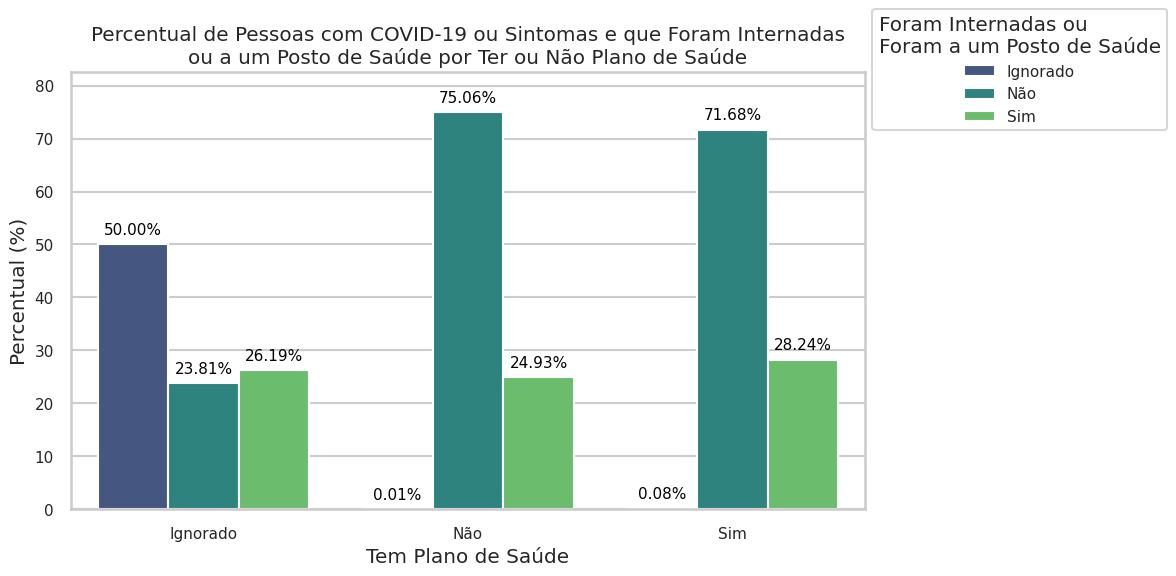

In [180]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19 ou teve COVID-19 confirmado
df_filtrado = df_pandas[(df_pandas['teve_sintomas_covid'] == 'Sim') | (df_pandas['teve_covid'] == 'Sim')]

# Agrupando para obter a contagem por 'tem_plano_saude' e 'foi_ao_hospital'
df_sintomas_covid_plano = df_filtrado.groupby(['tem_plano_saude', 'foi_ao_hospital']).size().reset_index(name='count')

# Calculando o percentual em relação ao total de pessoas em cada grupo de 'tem_plano_saude'
df_sintomas_covid_plano['percentual'] = df_sintomas_covid_plano.groupby('tem_plano_saude')['count'].transform(lambda x: x / x.sum() * 100)

# Criando o gráfico de barras para o percentual de pessoas
plt.figure(figsize=(12, 6))  # Tamanho do gráfico conforme solicitado
ax = sns.barplot(data=df_sintomas_covid_plano, x='tem_plano_saude', y='percentual', hue='foi_ao_hospital', palette='viridis')

# Adicionando rótulos e título ao gráfico com quebra de linha no título
plt.title('Percentual de Pessoas com COVID-19 ou Sintomas e que Foram Internadas\nou a um Posto de Saúde por Ter ou Não Plano de Saúde')
plt.xlabel('Tem Plano de Saúde')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

# Ajustar a posição da legenda para fora do gráfico
plt.legend(title='Foram Internadas ou\nForam a um Posto de Saúde', loc='center left', bbox_to_anchor=(1, 1.005), fontsize=11)

# Adicionando os valores no topo das barras com ajuste de posição
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:  # Verifica se a altura não é NaN e se é maior que 0
        ax.annotate(f'{height:.2f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', 
                    fontsize=11, color='black', xytext=(0, 5), 
                    textcoords='offset points')

# Ajustar o limite superior do eixo Y para dar mais espaço para os rótulos
ax.set_ylim(0, df_sintomas_covid_plano['percentual'].max() * 1.1)

# Exibindo o gráfico
plt.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()

/tmp/ipykernel_2412/156562789.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_top_5_uf, x='uf', y='count', palette='viridis')


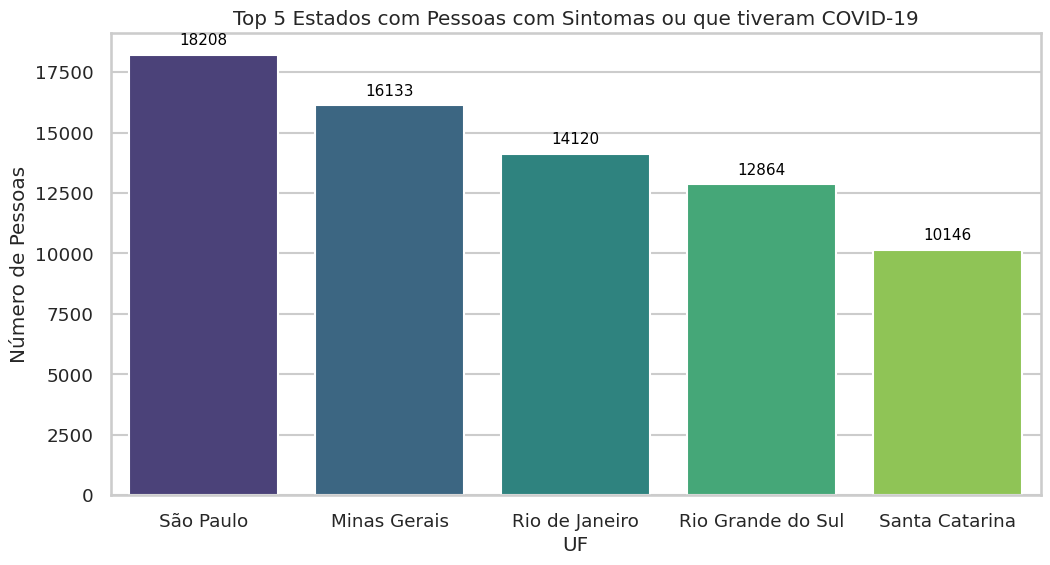

In [178]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19 ou teve COVID-19 confirmado
df_filtrado = df_pandas[(df_pandas['teve_sintomas_covid'] == 'Sim') | (df_pandas['teve_covid'] == 'Sim')]

# Agrupando por UF e contando o número de registros
df_uf = df_filtrado.groupby('uf').size().reset_index(name='count')

# Selecionando os 10 maiores valores por UF
df_top_5_uf = df_uf.nlargest(5, 'count')

# Ordenando os valores para melhor visualização
df_top_5_uf = df_top_5_uf.sort_values(by='count', ascending=False)

# Criando o gráfico de barras com os 5 estados de maior contagem
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_top_5_uf, x='uf', y='count', palette='viridis')

# Adicionando rótulos e título ao gráfico
plt.title('Top 5 Estados com Pessoas com Sintomas ou que tiveram COVID-19')
plt.xlabel('UF')
plt.ylabel('Número de Pessoas')

# Adicionando os valores no topo das barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Exibindo o gráfico
plt.show()

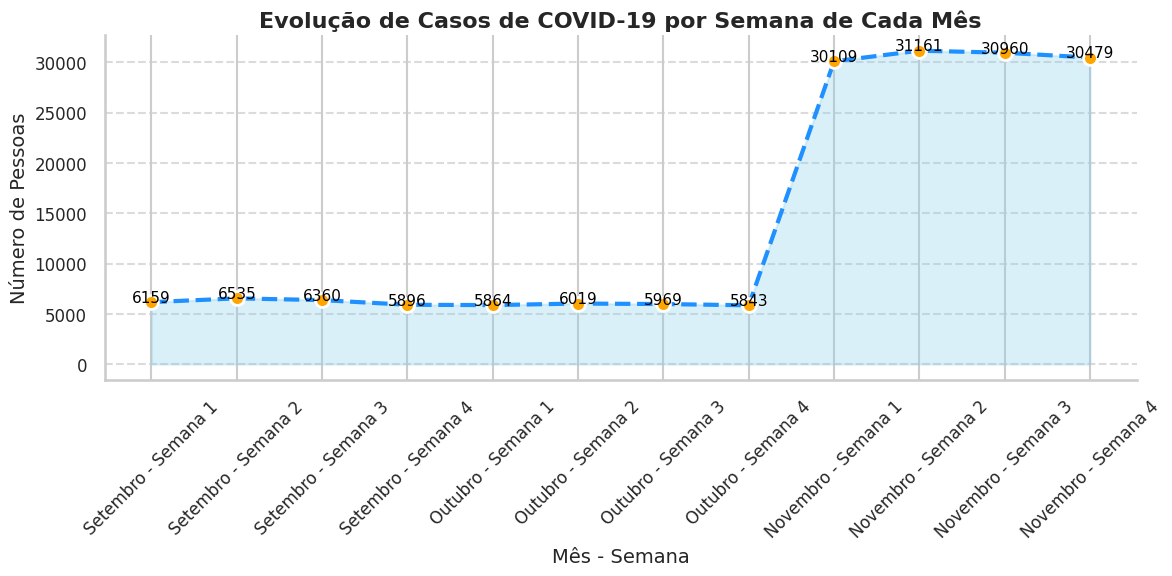

In [181]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19 ou teve COVID-19 confirmado
df_filtrado = df_pandas[(df_pandas['teve_sintomas_covid'] == 'Sim') | (df_pandas['teve_covid'] == 'Sim')]

# Agrupando por mês e semana do mês para obter a contagem de casos
df_evolucao_semanal_mes = df_filtrado.groupby(['mes', 'semana']).size().reset_index(name='count')

# Converter os números dos meses para nomes dos meses em português
meses_nome = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
df_evolucao_semanal_mes['mes_nome'] = df_evolucao_semanal_mes['mes'].map(meses_nome)

# Criando a coluna 'mes_semana' para facilitar o plot
df_evolucao_semanal_mes['mes_semana'] = df_evolucao_semanal_mes['mes_nome'] + ' - Semana ' + df_evolucao_semanal_mes['semana'].astype(str)

# Ordenando o DataFrame por mês e semana para garantir a sequência correta
df_evolucao_semanal_mes = df_evolucao_semanal_mes.sort_values(['mes', 'semana'])

# Criando o gráfico de linhas para mostrar a evolução de casos por semana do mês
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df_evolucao_semanal_mes,
    x='mes_semana', y='count',
    marker='o', color='dodgerblue',
    markersize=10, linewidth=3,
    markerfacecolor='orange', markeredgewidth=2,
    linestyle='--'
)

# Adicionando área de preenchimento sob a curva para destaque
ax.fill_between(df_evolucao_semanal_mes['mes_semana'], df_evolucao_semanal_mes['count'], color='skyblue', alpha=0.3)

# Adicionando rótulos e título ao gráfico com tamanhos e estilos de fonte ajustados
plt.title('Evolução de Casos de COVID-19 por Semana de Cada Mês', fontsize=16, fontweight='bold')
plt.xlabel('Mês - Semana', fontsize=14)
plt.ylabel('Número de Pessoas', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adicionando valores nos pontos da linha com fonte personalizada
for index, row in df_evolucao_semanal_mes.iterrows():
    plt.text(row['mes_semana'], row['count'] + 0.5, f"{int(row['count'])}", color='black', ha="center", fontsize=11)

# Remover bordas desnecessárias e exibir o gráfico com fundo ajustado
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adicionar grid apenas no eixo Y

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()